In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
from datetime import date
from mapper import cat_mapper, retail_mapper

np.set_printoptions(suppress=True)


pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 51)

In [2]:
csv_file_list = []
for i in os.listdir():
    if '.csv' in i.lower():
        csv_file_list.append(i)

In [3]:
def fidelity_credit_cleaner(frame):
    frame = frame.rename(columns={'Name':'Description'})
    frame['Date'] = pd.to_datetime(frame['Date'])
    return frame

In [4]:
def chase_checking_cleaner(frame):
    frame = frame.rename(columns={'Posting Date': 'Date'})
    frame['Date'] = pd.to_datetime(frame['Date'])
    return frame
    

In [5]:
def chase_credit_cleaner(frame):
    frame = frame.drop('Post Date',axis=1)
    frame = frame.drop('Memo', axis=1)
    
    frame = frame.rename(columns={'Transaction Date':'Date'})
    frame['Date'] = pd.to_datetime(frame['Date'])
    # frame['Amount'] = frame['Amount'] * -1
    return frame
    

In [6]:
def amex_credit_cleaner(frame):
    frame['Date'] = pd.to_datetime(frame['Date'])
    frame['Amount'] = frame['Amount'] * -1
    return frame
    

In [7]:
df = pd.DataFrame()
for i in csv_file_list:
    if 'amex' in i.lower():
        temp_df = pd.read_csv(i)
        
        temp_df = amex_credit_cleaner(temp_df)

        temp_df['file_name'] = i.split('.')[0]
        
        df = pd.concat([df, temp_df])
        # print('hello')
    elif ('chase' in i.lower()) & ('credit' in i.lower()):
        temp_df = pd.read_csv(i)
       
        # Transform to fit amex transactions
        temp_df = chase_credit_cleaner(temp_df)

        temp_df['file_name'] = i.split('.')[0]
       
        df = pd.concat([df, temp_df])
    elif ('chase' in i.lower()) & ('checking' in i.lower()):
        temp_df = pd.read_csv(i,index_col=False)
        temp_df = chase_checking_cleaner(temp_df)
        temp_df['file_name'] = i.split('.')[0]

        df = pd.concat([df, temp_df])
    elif ('fidelity' in i.lower()) & ('credit' in i.lower()):
        temp_df = pd.read_csv(i, index_col=False)
        temp_df = fidelity_credit_cleaner(temp_df)
        temp_df['file_name'] = i.split('.')[0]

        df = pd.concat([df, temp_df])

    elif ('clean' in i.lower()):
        temp_df = pd.read_csv(i, index_col=False)
        temp_df['Date'] = pd.to_datetime(temp_df['Date'])
        temp_df = temp_df.drop('Unnamed: 0', axis=1)
        df = pd.concat([df,temp_df])
        

In [8]:
df = df.reset_index(drop=True)

In [9]:
drop_col_list = df.columns[:20].to_list()
df = df.drop_duplicates(subset=drop_col_list)

### Feature creation for Analysis

In [10]:
df['bank'] = df['file_name'].str.split('_').str[0]
df['account_type'] = df['file_name'].str.split('_').str[1]
df['account_number'] = df['file_name'].str.split('_').str[2]

df['month_name'] = df['Date'].dt.month_name()
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year.astype('Int64')
df['month_year'] = df['month_name'].str[:3] + "-" + df['year'].astype('str')

In [11]:
#create conditions to filter results that do no benefit from removing numbers and spaces from the Description column
## default result removes all numbers and extra spaces from the description column

cond = [
    df['Description'].str.contains('amex',case=False),
]

choice = [
    df['Description'],
]

default_cond = df['Description'].str.replace(r'\d+','',regex=True).str.replace(r'\s+'," ", regex=True)

df['clean_description'] = np.select(condlist=cond,choicelist=choice,default=default_cond)



In [12]:
#Sort all transactions then shift by 1 and compare to find recurring transactions

df = df.sort_values(['clean_description', 'year','month','Amount'],ascending=[True,False,False, True])


shift_date = df.shift(-1)['Date'].dt.month.astype('Int8')
date_offset = (df['Date'] - pd.DateOffset(months=1)).dt.month
shift_amount = df.shift(-1)['Amount']

df['is_recurring'] = (shift_date == date_offset) & (df['Amount'] == shift_amount)

In [13]:
#Some transactions Are not getting flagged as recurring with the current conditions for various reasons including Bi-weekly payments, variable amount etc.
##Tag some transactions as always recurring and define specific transactions that should never be flagged as recurring

cond = [
    df['Description'].str.contains('first national bank',case=False),
    df['Description'].str.contains('kids kampus',case=False),
]

choice = [
    1,
    1,
]

default_cond = df['is_recurring']

df['is_recurring'] = np.select(cond, choice, default_cond)

### Cleaning and Data mapping

In [14]:
#Establish baseline for null count analysis

og_null_count = df.isnull().sum()
og_null_count = og_null_count.to_frame('original_null_count')
og_null_count

,original_null_count
Date,0
Description,0
Card Member,2724
Account #,2724
Amount,0
Extended Details,2724
Appears On Your Statement As,2724
Address,2807
City/State,2808
Zip Code,2808


In [15]:
df = cat_mapper(df, 'Description','Category')

In [16]:
#add null count values after cleaning and calculate percentage change

new_null_count = df.isnull().sum().to_frame('cleaned_null_count')
null_count_df = og_null_count.merge(new_null_count, left_index=True, right_index=True)
null_count_df['percent_null_count_difference'] =round((null_count_df['original_null_count']-null_count_df['cleaned_null_count'])/null_count_df['original_null_count'],2)
null_count_df['percent_null_count_difference'] = null_count_df['percent_null_count_difference'].fillna(0.00)


In [17]:
df['clean_description'].str.strip().sort_values().unique()[:30]

array(['$ Disney Bundle Credit', '- NORTH GREEN', '- NORTH LACHICAGO IL',
       '- NORTH LAKE SH', '-TOR RELAY T TRMISSISSAUGA',
       '-TOR RELAY TERM MISSISSAUGA', 'ABT ELECTRONICS',
       'ACORN TIRE & SERVICENAPERVILLE IL', 'ACT*Dupage Forest',
       'ACT*Dupage Forest - IL', 'ADJ REDIST PURCHASE BAL', 'AIR CAN*',
       'AIR CANADA', 'AIR TRANSAT SXJFY', 'ALLEGORY -NAPERVILLE IL',
       'ALLY LENDING - NY /', 'ALLY LENDING -- - NY /',
       'AMAZON RET* - WWW.AMAZON.CO WA', 'AMAZON.COM*AKY SEATTLE WA',
       'AMAZON.COM*CHQH SEATTLE WA', 'AMAZON.COM*DYJK SEATTLE WA',
       'AMAZON.COM*EVZY SEATTLE WA', 'AMAZON.COM*JIJN SEATTLE WA',
       'AMAZON.COM*JJPPX SEATTLE WA', 'AMAZON.COM*JSB SEATTLE WA',
       'AMAZON.COM*KHS SEATTLE WA', 'AMAZON.COM*KQUMYY SEATTLE WA',
       'AMAZON.COM*KRHN SEATTLE WA', 'AMAZON.COM*ME SEATTLE WA',
       'AMAZON.COM*NUACQ SEATTLE WA'], dtype=object)

In [18]:
null_count_df

,original_null_count,cleaned_null_count,percent_null_count_difference
Date,0,0,0.0
Description,0,0,0.0
Card Member,2724,2724,0.0
Account #,2724,2724,0.0
Amount,0,0,0.0
Extended Details,2724,2724,0.0
Appears On Your Statement As,2724,2724,0.0
Address,2807,2807,0.0
City/State,2808,2808,0.0
Zip Code,2808,2808,0.0


In [23]:
retail_mapper(df, 'Description','Retailer')['Retailer'].value_counts()

Retailer
Unknown                   2767
Amazon                     670
Air Canada                   9
Air Transat                  2
ABT Electronics              1
Acorn Tire and Service       1
Name: count, dtype: int64

In [21]:
df = df.sort_values('Date', ascending=False)

In [39]:
targ_string = 'applecard'

df[df['Description'].str.contains(targ_string,case=False) ]

,Date,Description,Card Member,Account #,Amount,Extended Details,Appears On Your Statement As,Address,City/State,Zip Code,Country,Reference,Category,file_name,Details,Type,Balance,Check or Slip #,Transaction,Memo,bank,account_type,account_number,clean_description,month_name,month,year,month_year,is_recurring
735,2024-05-31,APPLECARD GSBANK PAYMENT 19314999 WE...,NaN,NaN,-774.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_9333_Activity_20240611,DEBIT,ACH_DEBIT,13497.31,NaN,NaN,NaN,Chase,checking,9333,APPLECARD GSBANK PAYMENT WEB ID:,May,5,2024,May-2024,0
762,2024-04-29,APPLECARD GSBANK PAYMENT 19314999 WE...,NaN,NaN,-633.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_9333_Activity_20240611,DEBIT,ACH_DEBIT,3007.81,NaN,NaN,NaN,Chase,checking,9333,APPLECARD GSBANK PAYMENT WEB ID:,April,4,2024,Apr-2024,0
778,2024-04-01,APPLECARD GSBANK PAYMENT 19314999 WE...,NaN,NaN,-633.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_9333_Activity_20240611,DEBIT,ACH_DEBIT,4034.83,NaN,NaN,NaN,Chase,checking,9333,APPLECARD GSBANK PAYMENT WEB ID:,April,4,2024,Apr-2024,0
799,2024-03-01,APPLECARD GSBANK PAYMENT 19314999 WE...,NaN,NaN,-400.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_9333_Activity_20240611,DEBIT,ACH_DEBIT,6873.70,NaN,NaN,NaN,Chase,checking,9333,APPLECARD GSBANK PAYMENT WEB ID:,March,3,2024,Mar-2024,0
828,2024-01-29,APPLECARD GSBANK PAYMENT 19314999 WE...,NaN,NaN,-1059.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_9333_Activity_20240611,DEBIT,ACH_DEBIT,11468.91,NaN,NaN,NaN,Chase,checking,9333,APPLECARD GSBANK PAYMENT WEB ID:,January,1,2024,Jan-2024,0
847,2024-01-02,APPLECARD GSBANK PAYMENT 19314999 WE...,NaN,NaN,-325.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_9333_Activity_20240611,DEBIT,ACH_DEBIT,10009.47,NaN,NaN,NaN,Chase,checking,9333,APPLECARD GSBANK PAYMENT WEB ID:,January,1,2024,Jan-2024,0
880,2023-12-01,APPLECARD GSBANK PAYMENT 19314999 WE...,NaN,NaN,-200.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_9333_Activity_20240611,DEBIT,ACH_DEBIT,20978.79,NaN,NaN,NaN,Chase,checking,9333,APPLECARD GSBANK PAYMENT WEB ID:,December,12,2023,Dec-2023,0
909,2023-10-26,APPLECARD GSBANK PAYMENT 19314999 WE...,NaN,NaN,-200.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_9333_Activity_20240611,DEBIT,ACH_DEBIT,4677.08,NaN,NaN,NaN,Chase,checking,9333,APPLECARD GSBANK PAYMENT WEB ID:,October,10,2023,Oct-2023,0
928,2023-10-02,APPLECARD GSBANK PAYMENT 19314999 WE...,NaN,NaN,-175.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_9333_Activity_20240611,DEBIT,ACH_DEBIT,4079.37,NaN,NaN,NaN,Chase,checking,9333,APPLECARD GSBANK PAYMENT WEB ID:,October,10,2023,Oct-2023,0
957,2023-08-29,APPLECARD GSBANK PAYMENT 19314999 WE...,NaN,NaN,-175.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_9333_Activity_20240611,DEBIT,ACH_DEBIT,1552.17,NaN,NaN,NaN,Chase,checking,9333,APPLECARD GSBANK PAYMENT WEB ID:,August,8,2023,Aug-2023,0


In [34]:
df['Description'].str[0:5]

1928    73209
602     72488
1854    72488
233     61828
232     61828
        ...  
2274    rawso
2506    rawso
3178    rawso
1988    world
2002    world
Name: Description, Length: 3450, dtype: object

In [38]:
df[df['Category'].isnull()].groupby(df['Description'].str[0:15])['Description'].count().sort_values(ascending=False)[:20]

Description
AMEX EPAYMENT      92
Payment Thank Y    62
Payment to Chas    55
AMERICAN EXPRES    52
ONLINE PAYMENT     35
Online Payment     29
GLANBIA PERFORM    29
DISCOVER BANK      26
APPLECARD GSBAN    24
AUTOMATIC PAYME    23
CHASE CREDIT CR    23
VENMO              21
ALLY LENDING 88    19
ATM WITHDRAWAL     17
WELLMORE HOLDIN    17
CAPITAL ONE        16
AUTOPAY PAYMENT    15
Kabbage            15
DISCOVER            9
REMOTE ONLINE D     7
Name: Description, dtype: int64

In [93]:
max_date = str((df['Date'].dt.date.max()))
min_date = str((df['Date'].dt.date.min()))


file_name = "clean_" + min_date + "_"  + max_date
print(file_name)

clean_2022-06-11_2024-06-11


In [94]:
df.to_csv(file_name+'.csv')

PermissionError: [Errno 13] Permission denied: 'clean_2022-06-11_2024-06-11.csv'

### Analyze the recurring transactions

In [95]:
df[df['is_recurring'] == True]

,Date,Description,Card Member,Account #,Amount,Extended Details,Appears On Your Statement As,Address,City/State,Zip Code,Country,Reference,Category,file_name,Details,Type,Balance,Check or Slip #,Transaction,Memo,bank,account_type,account_number,clean_description,month_name,month,year,month_year,is_recurring
3216,2024-06-07,KRISERS NAPERVILLE NAPERVILLE IL,NaN,NaN,-101.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fidelity_credit_1925,NaN,NaN,NaN,NaN,DEBIT,24017944159001353460048; 05995; ; ; ;,fidelity,credit,1925,KRISERS NAPERVILLE NAPERVILLE IL,June,6,2024,Jun-2024,1
3215,2024-06-07,THE CLEANING AUTHORITY 847-302-3909 IL,NaN,NaN,-229.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fidelity_credit_1925,NaN,NaN,NaN,NaN,DEBIT,24269794158300697092334; 07349; ; ; ;,fidelity,credit,1925,THE CLEANING AUTHORITY -- IL,June,6,2024,Jun-2024,1
2856,2024-06-04,FOREIGN TRANSACTION FEE,NaN,NaN,-0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fees & Adjustments,Chase_credit_4649_20220611_20240611,NaN,Fee,NaN,NaN,NaN,NaN,Chase,credit,4649,FOREIGN TRANSACTION FEE,June,6,2024,Jun-2024,1
3232,2024-06-04,AMZ*Protea Nutrition pay.amazon.co SD,NaN,NaN,-57.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fidelity_credit_1925,NaN,NaN,NaN,NaN,DEBIT,24692164155109830081898; 05499; ; ; ;,fidelity,credit,1925,AMZ*Protea Nutrition pay.amazon.co SD,June,6,2024,Jun-2024,1
733,2024-06-03,KIDS KAMPUS CHIL 6305770046 PP...,NaN,NaN,-1595.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_9333_Activity_20240611,DEBIT,ACH_DEBIT,11635.31,NaN,NaN,NaN,Chase,checking,9333,KIDS KAMPUS CHIL PPD ID:,June,6,2024,Jun-2024,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,2022-07-08,GLANBIA PERFORMA DIRECT DEP PP...,NaN,NaN,5544.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_9333_Activity_20240611,CREDIT,ACH_CREDIT,14360.70,NaN,NaN,NaN,Chase,checking,9333,GLANBIA PERFORMA DIRECT DEP PPD ID:,July,7,2022,Jul-2022,1
3173,2022-07-05,STAX *AKITA SECURIT,NaN,NaN,-45.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Professional Services,Chase_credit_4649_20220611_20240611,NaN,Sale,NaN,NaN,NaN,NaN,Chase,credit,4649,STAX *AKITA SECURIT,July,7,2022,Jul-2022,1
1321,2022-07-05,KIDS KAMPUS INC 6305770046 PP...,NaN,NaN,-840.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_9333_Activity_20240611,DEBIT,ACH_DEBIT,16458.42,NaN,NaN,NaN,Chase,checking,9333,KIDS KAMPUS INC PPD ID:,July,7,2022,Jul-2022,1
1330,2022-06-24,Online Payment 14412690514 To First National B...,NaN,NaN,-5582.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_9333_Activity_20240611,DEBIT,BILLPAY,22752.89,NaN,NaN,NaN,Chase,checking,9333,Online Payment To First National Bank of Ottawa /,June,6,2022,Jun-2022,1


In [76]:
df

,Date,Description,Card Member,Account #,Amount,Extended Details,Appears On Your Statement As,Address,City/State,Zip Code,Country,Reference,Category,file_name,Details,Type,Balance,Check or Slip #,Transaction,Memo,bank,account_type,account_number,clean_description,month_name,month,year,month_year,is_recurring
0,2022-12-29,MOBILE PAYMENT - THANK YOU,BRUCE LOMBARD,-91002.0,2673.40,MOBILE PAYMENT - THANK YOU,MOBILE PAYMENT - THANK YOU,NaN,NaN,NaN,NaN,'320223630765283073',NaN,amex_credit_1002_bce_2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-12-21,THE DISNEY BUNDLE CREDIT,BRUCE LOMBARD,-91002.0,7.00,THE DISNEY BUNDLE CREDIT,THE DISNEY BUNDLE CREDIT,2500 BROADWAY,SANTA MONICA\r\nCA,90404-3065,UNITED STATES,'320223550614393280',Communications-Cable & Internet Comm,amex_credit_1002_bce_2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-12-17,1707 S WASHINGTON STNAPERVILLE IL,BRUCE LOMBARD,-91002.0,-49.49,00000004401 6303550157\r\n1707 S WASHINGTON ST...,1707 S WASHINGTON STNAPERVILLE IL,12700 NORTHBOROUGH DR,HOUSTON\r\nTX,77067-2552,UNITED STATES,'320223520535625915',Transportation-Fuel,amex_credit_1002_bce_2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-12-17,JEWEL OSCO 1111 1111NAPERVILLE IL,BRUCE LOMBARD,-91002.0,-35.92,0124137 800-898-4027\r\nJEWEL OSCO 1111 11...,JEWEL OSCO 1111 1111NAPERVILLE IL,1227 NAPER BLVD,NAPERVILLE\r\nIL,60540,UNITED STATES,'320223520526343876',Merchandise & Supplies-Groceries,amex_credit_1002_bce_2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-12-17,WHOLEFDS NPV 10129 0NAPERVILLE IL,BRUCE LOMBARD,-91002.0,-90.91,0C2LHY492MF 6305797700\r\nWHOLEFDS NPV 10129 0...,WHOLEFDS NPV 10129 0NAPERVILLE IL,2607 WEST 75TH ST,NAPERVILLE\r\nIL,60540,UNITED STATES,'320223520532548570',Merchandise & Supplies-Groceries,amex_credit_1002_bce_2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3912,2024-01-25,VOLVO OF LISLE LISLE IL,NaN,NaN,-41.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fidelity_credit_1925,NaN,NaN,NaN,NaN,DEBIT,24223694024017018208550; 05511; ; ; ;,fidelity,credit,1925.0,VOLVO OF LISLE LISLE IL,January,1.0,2024.0,Jan-2024,0.0
3914,2024-01-24,AMZN Mktp US*R85620RN2 Amzn.com/bill WA,NaN,NaN,-64.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fidelity_credit_1925,NaN,NaN,NaN,NaN,DEBIT,24692164023100182924801; 05942; ; ; ;,fidelity,credit,1925.0,AMZN Mktp US*RRN Amzn.com/bill WA,January,1.0,2024.0,Jan-2024,0.0
3916,2024-01-23,SIF CAR CARE LLC NAPERVILLE IL,NaN,NaN,-15.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fidelity_credit_1925,NaN,NaN,NaN,NaN,DEBIT,24269794022500518994535; 07542; ; ; ;,fidelity,credit,1925.0,SIF CAR CARE LLC NAPERVILLE IL,January,1.0,2024.0,Jan-2024,0.0
3918,2024-01-22,COSTCO WHSE#1443 NAPERVILLE IL,NaN,NaN,-3.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fidelity_credit_1925,NaN,NaN,NaN,NaN,DEBIT,24943004022898002358979; 05300; ; ; ;,fidelity,credit,1925.0,COSTCO WHSE# NAPERVILLE IL,January,1.0,2024.0,Jan-2024,0.0


In [96]:
recur = df[df['is_recurring'] == True]

In [97]:
# recur2 = 
# recur['adjusted_amount'] = np.where(recur['account_type']=='credit',recur['Amount']*-1,recur['Amount'])

In [98]:
recur = recur.sort_values('Date')

In [99]:
# recur_group = recur.groupby('month_year',as_index=False,sort=False)['adjusted_amount'].sum()
recur_group = recur.groupby('month_year',as_index=False,sort=False)['Amount'].sum()

In [100]:
recur_group['Amount'] = recur_group['Amount']*-1

In [101]:
recur_group

,month_year,Amount
0,Jun-2022,6422.38
1,Jul-2022,3364.30
2,Aug-2022,9007.10
3,Sep-2022,8396.43
4,Oct-2022,8833.45
5,Nov-2022,8361.46
6,Dec-2022,2952.32
7,Jan-2023,9379.67
8,Feb-2023,3257.54
9,Mar-2023,8250.45


In [102]:
recur.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381 entries, 1335 to 3216
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          381 non-null    datetime64[ns]
 1   Description                   381 non-null    object        
 2   Card Member                   38 non-null     object        
 3   Account #                     38 non-null     float64       
 4   Amount                        381 non-null    float64       
 5   Extended Details              38 non-null     object        
 6   Appears On Your Statement As  38 non-null     object        
 7   Address                       34 non-null     object        
 8   City/State                    34 non-null     object        
 9   Zip Code                      34 non-null     object        
 10  Country                       34 non-null     object        
 11  Reference                     38 

In [103]:
recur[recur['month_year'] == 'May-2024']

,Date,Description,Card Member,Account #,Amount,Extended Details,Appears On Your Statement As,Address,City/State,Zip Code,Country,Reference,Category,file_name,Details,Type,Balance,Check or Slip #,Transaction,Memo,bank,account_type,account_number,clean_description,month_name,month,year,month_year,is_recurring
659,2024-05-03,TST* SPARROW COFFEE NAPERVILLE IL,BRUCE LOMBARD,-71004.0,-15.85,21105174125 312-648-6415\r\nTST* SPARROW COFFE...,TST* SPARROW COFFEE NAPERVILLE IL,120 WATER ST STE 110,NAPERVILLE\r\nIL,60540,UNITED STATES,'320241250578453066',Restaurant-Restaurant,amex_credit_1004_gold_2024_ytd,NaN,NaN,NaN,NaN,NaN,NaN,amex,credit,1004,TST* SPARROW COFFEE NAPERVILLE IL,May,5,2024,May-2024,1
3433,2024-05-03,THE CLEANING AUTHORITY 847-302-3909 IL,NaN,NaN,-229.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fidelity_credit_1925,NaN,NaN,NaN,NaN,DEBIT,24269794123300730990769; 07349; ; ; ;,fidelity,credit,1925,THE CLEANING AUTHORITY -- IL,May,5,2024,May-2024,1
2863,2024-05-05,FOREIGN TRANSACTION FEE,NaN,NaN,-0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fees & Adjustments,Chase_credit_4649_20220611_20240611,NaN,Fee,NaN,NaN,NaN,NaN,Chase,credit,4649,FOREIGN TRANSACTION FEE,May,5,2024,May-2024,1
2014,2024-05-06,Akita Security Inc.,NaN,NaN,-45.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Professional Services,Chase_credit_4434_20220611_20240611,NaN,Sale,NaN,NaN,NaN,NaN,Chase,credit,4434,Akita Security Inc.,May,5,2024,May-2024,1
1380,2024-05-06,LinkedIn Pre 9530668406,NaN,NaN,-69.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bills & Utilities,Chase_credit_3326_20220611_20240611,NaN,Sale,NaN,NaN,NaN,NaN,Chase,credit,3326,LinkedIn Pre,May,5,2024,May-2024,1
3417,2024-05-06,AMZ*Protea Nutrition pay.amazon.co SD,NaN,NaN,-57.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fidelity_credit_1925,NaN,NaN,NaN,NaN,DEBIT,24692164124106798322916; 05499; ; ; ;,fidelity,credit,1925,AMZ*Protea Nutrition pay.amazon.co SD,May,5,2024,May-2024,1
754,2024-05-06,KIDS KAMPUS CHIL 6305770046 PP...,NaN,NaN,-1595.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Chase_checking_9333_Activity_20240611,DEBIT,ACH_DEBIT,18185.59,NaN,NaN,NaN,Chase,checking,9333,KIDS KAMPUS CHIL PPD ID:,May,5,2024,May-2024,1
2012,2024-05-07,WWW.HIBOBBIE.COM,NaN,NaN,-274.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shopping,Chase_credit_4434_20220611_20240611,NaN,Sale,NaN,NaN,NaN,NaN,Chase,credit,4434,WWW.HIBOBBIE.COM,May,5,2024,May-2024,1
2010,2024-05-09,SP HIYA HEALTH,NaN,NaN,-37.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Groceries,Chase_credit_4434_20220611_20240611,NaN,Sale,NaN,NaN,NaN,NaN,Chase,credit,4434,SP HIYA HEALTH,May,5,2024,May-2024,1
296,2024-05-16,HULU 877-8244858 CA HULU.COM/BILL CA,BRUCE LOMBARD,-91002.0,-24.99,427814995:7 HULU.COM/BILL\r\nHULU 877-8244858 ...,HULU 877-8244858 CA HULU.COM/BILL CA,2500 BROADWAY,SANTA MONICA\r\nCA,90404-3065,UNITED STATES,'320241370875456327',Communications-Cable & Internet Comm,amex_credit_1002_bce_2024_ytd,NaN,NaN,NaN,NaN,NaN,NaN,amex,credit,1002,HULU - CA HULU.COM/BILL CA,May,5,2024,May-2024,1


In [104]:
recur_group

,month_year,Amount
0,Jun-2022,6422.38
1,Jul-2022,3364.30
2,Aug-2022,9007.10
3,Sep-2022,8396.43
4,Oct-2022,8833.45
5,Nov-2022,8361.46
6,Dec-2022,2952.32
7,Jan-2023,9379.67
8,Feb-2023,3257.54
9,Mar-2023,8250.45


C:\Users\blomb\AppData\Local\Temp\ipykernel_1608\2725235881.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(recur_group, x='month_year', y='Amount',palette='viridis')


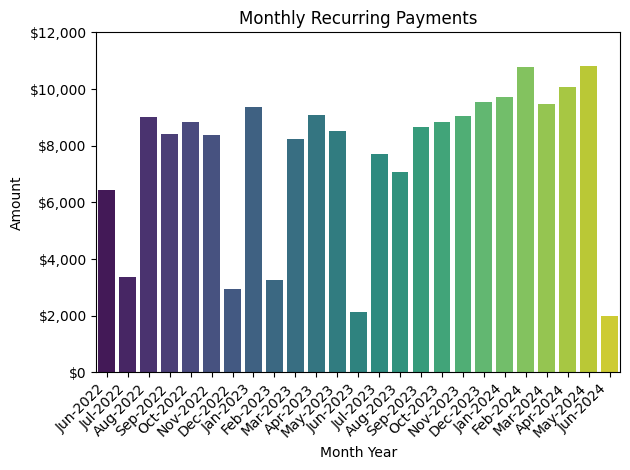

In [121]:

# plt.figure(figsize=(8,6), dpi=200)
g = sns.barplot(recur_group, x='month_year', y='Amount',palette='viridis')
plt.xticks(rotation=45, horizontalalignment='right')
plt.yticks(ticks =[x for x in g.get_yticks()],labels=['${:,.0f}'.format(x) for x in g.get_yticks()])
plt.xlabel('Month Year')
plt.ylabel('Amount')
plt.title('Monthly Recurring Payments')
plt.tight_layout()



plt.show()